In [26]:
import datetime
from functools import partial

import os
import numpy as np
import pandas as pd
from dataloaders import loadfile

In [27]:
import bayesflow.diagnostics as diag
from bayesflow.amortizers import AmortizedPosterior
from bayesflow.networks import InvertibleNetwork, SequenceNetwork
from bayesflow.simulation import GenerativeModel, Prior, Simulator
from bayesflow.trainers import Trainer

In [28]:
RNG = np.random.default_rng(2023)
HOME = os.getenv("HOME")

In [29]:
dac = loadfile(f"{HOME}/Datasets/cell_migration/dac.txt")
msd = loadfile(f"{HOME}/Datasets/cell_migration/msd.txt")
params = loadfile(f"{HOME}/Datasets/cell_migration/parameters.txt")

In [30]:
prior = Prior(prior_fun=params.__next__, param_names=["A", "B", "C", "D", "E"])
prior_means, prior_stds = prior.estimate_means_and_stds()
print(prior_means, prior_stds)

[[ 1.47655815  1.47929192  1.48780488  1.50690028 13.39114469]] [[ 2.36635041  2.25326833  2.38332821  2.31952007 22.24352688]]


In [31]:
simulator = Simulator(simulator_fun=lambda _: np.array(next(msd)).reshape(-1, 1))

In [32]:
model = GenerativeModel(prior, simulator, name="basic_covid_simulator")

INFO:root:Performing 2 pilot runs with the basic_covid_simulator model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 5)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 80, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [33]:
# As per default, the plot_prior2d function will obtain 1000 draws from the joint prior.
f = prior.plot_prior2d()

In [ ]:
summary_net = SequenceNetwork()

In [ ]:
inference_net = InvertibleNetwork(num_params=len(prior.param_names), num_coupling_layers=4)

In [ ]:
amortizer = AmortizedPosterior(inference_net, summary_net, name="covid_amortizer")

In [ ]:
def configure_input(forward_dict):
    """Function to configure the simulated quantities (i.e., simulator outputs)
    into a neural network-friendly (BayesFlow) format.
    """

    # Convert data to logscale
    data = forward_dict["sim_data"].astype(np.float32)

    # Extract prior draws and z-standardize with previously computed means
    params = forward_dict["prior_draws"].astype(np.float32)
    params = (params - prior_means) / prior_stds

    # Remove a batch if it contains nan, inf or -inf
    # idx_keep = np.all(np.isfinite(data), axis=(1, 2))
    # if not np.all(idx_keep):
    #     print("Invalid value encountered...removing from batch")

    return {
        "summary_conditions": data,
        "parameters": params
    }

trainer = Trainer(amortizer=amortizer, generative_model=model, configurator=configure_input, memory=True)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [ ]:
amortizer.summary()

Model: "covid_amortizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Invert  multiple                  297080    
 ibleNetwork)                                                    
                                                                 
 sequence_network (Sequence  multiple                  91178     
 Network)                                                        
                                                                 
Total params: 388258 (1.48 MB)
Trainable params: 388218 (1.48 MB)
Non-trainable params: 40 (160.00 Byte)
_________________________________________________________________


In [ ]:
# %%time
_ = model(32)

In [ ]:
offline_data = model(10000)

In [ ]:
# %%time
history = trainer.train_offline(offline_data, epochs=30, batch_size=32, validation_sims=200)

INFO:root:Generated 200 simulations for validation.
Training epoch 1: 100%|██████████| 313/313 [00:19<00:00, 16.09it/s, Epoch: 1, Batch: 313,Loss: 6.068,W.Decay: 0.089,Avg.Loss: 6.884,Avg.W.Decay: 0.134,LR: 4.99E-04]
INFO:root:Validation, Epoch: 1, Loss: 5.745
Training epoch 2: 100%|██████████| 313/313 [00:12<00:00, 24.59it/s, Epoch: 2, Batch: 313,Loss: 3.735,W.Decay: 0.089,Avg.Loss: 4.845,Avg.W.Decay: 0.088,LR: 4.95E-04]
INFO:root:Validation, Epoch: 2, Loss: 3.870
Training epoch 3: 100%|██████████| 313/313 [00:12<00:00, 25.13it/s, Epoch: 3, Batch: 313,Loss: 3.366,W.Decay: 0.090,Avg.Loss: 3.684,Avg.W.Decay: 0.090,LR: 4.88E-04]
INFO:root:Validation, Epoch: 3, Loss: 3.262
Training epoch 4: 100%|██████████| 313/313 [00:12<00:00, 25.22it/s, Epoch: 4, Batch: 313,Loss: 4.661,W.Decay: 0.091,Avg.Loss: 3.321,Avg.W.Decay: 0.091,LR: 4.78E-04]
INFO:root:Validation, Epoch: 4, Loss: 3.101
Training epoch 5: 100%|██████████| 313/313 [00:12<00:00, 25.60it/s, Epoch: 5, Batch: 313,Loss: 3.658,W.Decay: 0.

/Users/alisamar/Desktop/cell_migration_bayesflow/.venv/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


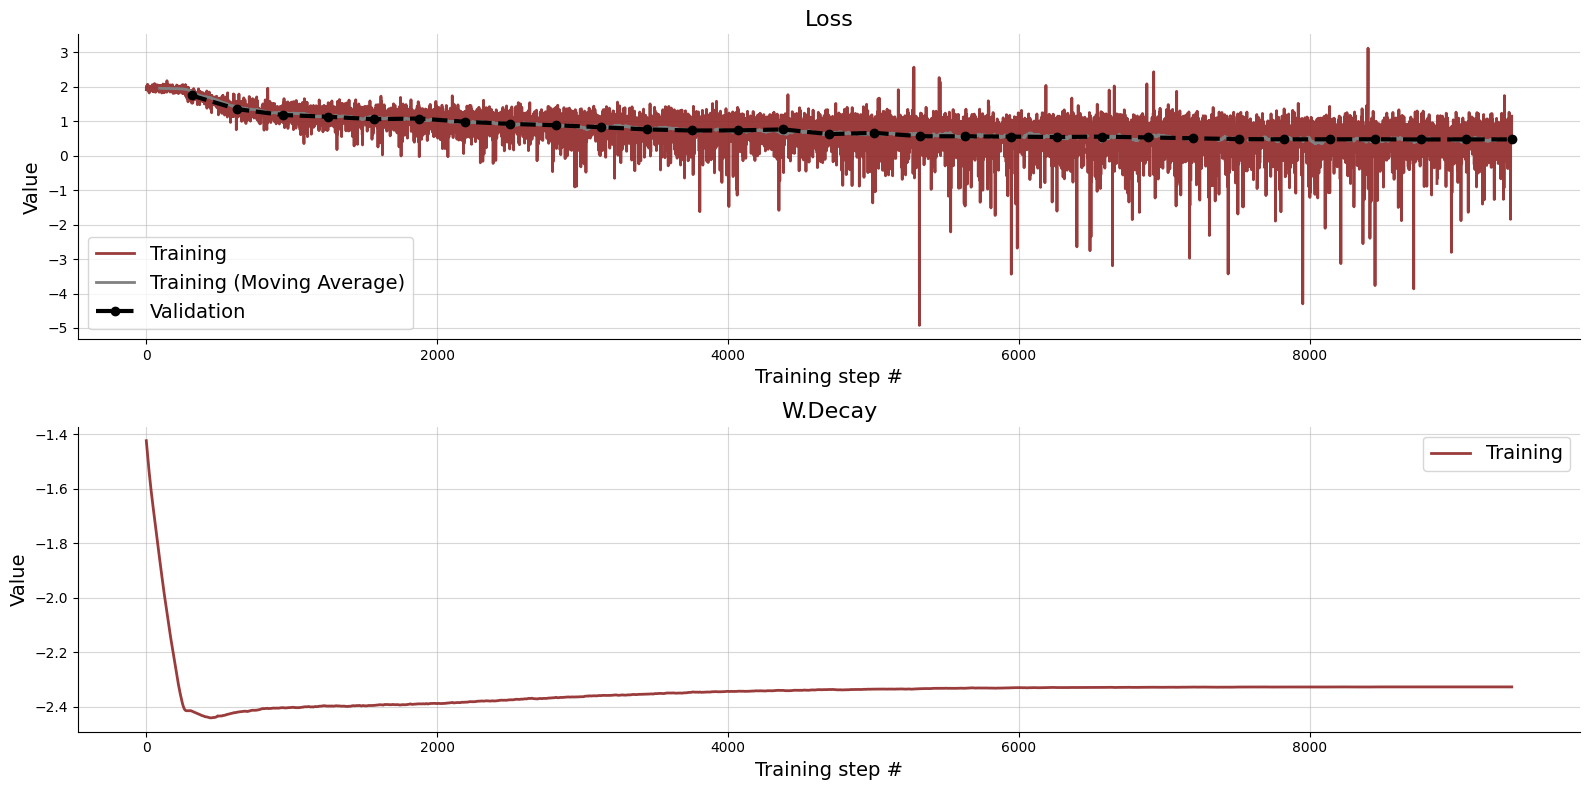

In [ ]:
f = diag.plot_losses(np.log(history["train_losses"]), np.log(history["val_losses"]), moving_average=True)

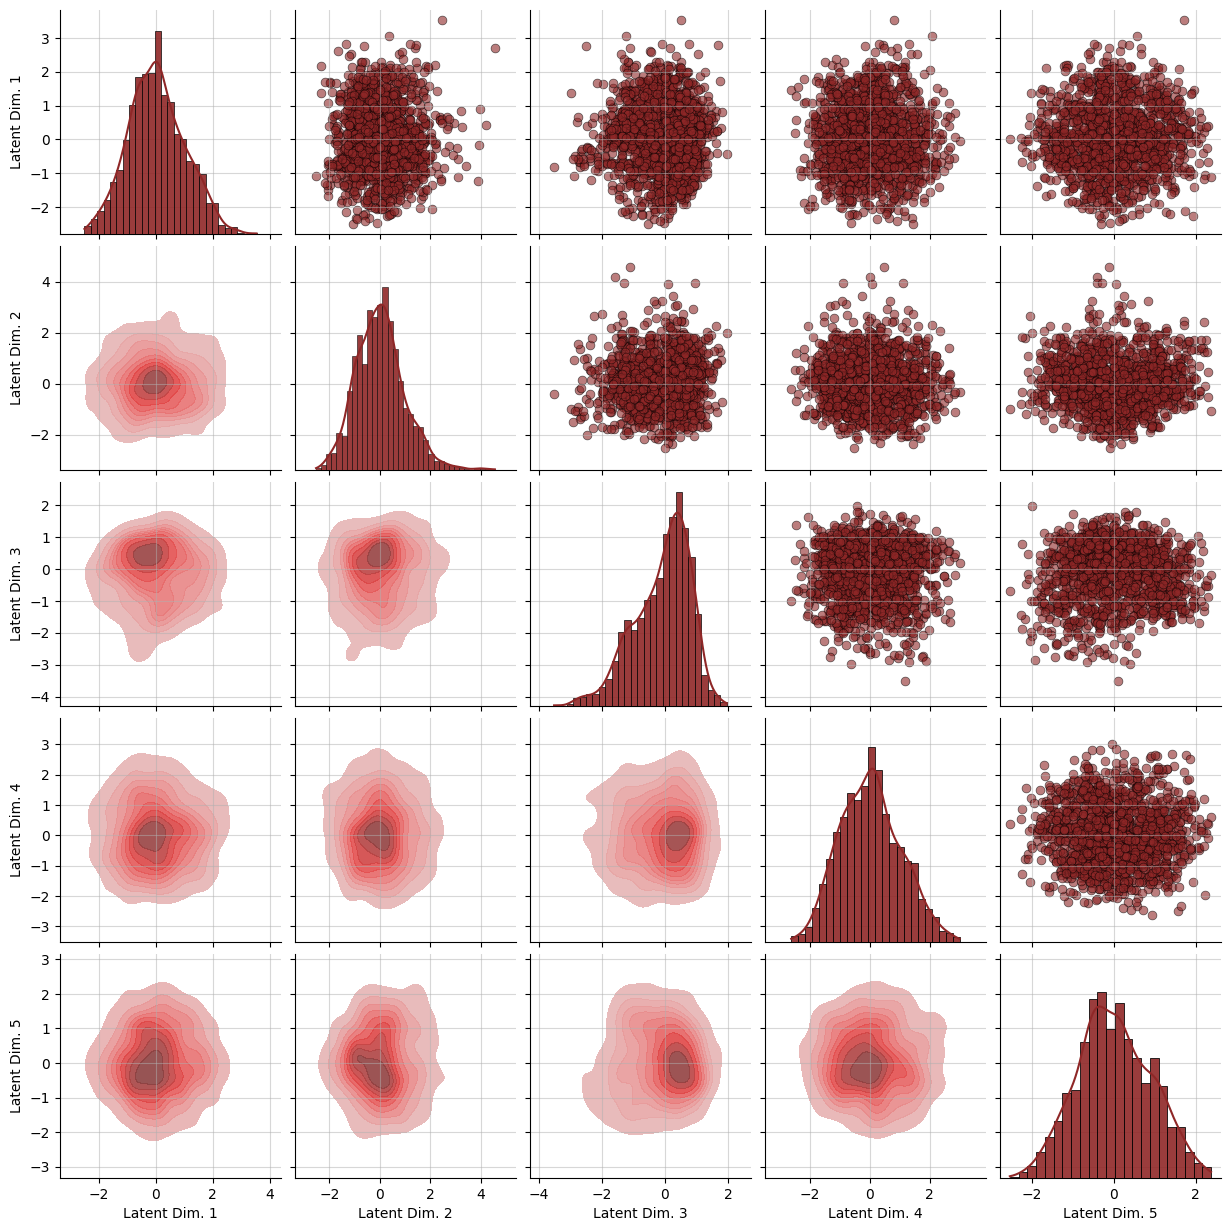

In [ ]:
f = trainer.diagnose_latent2d()

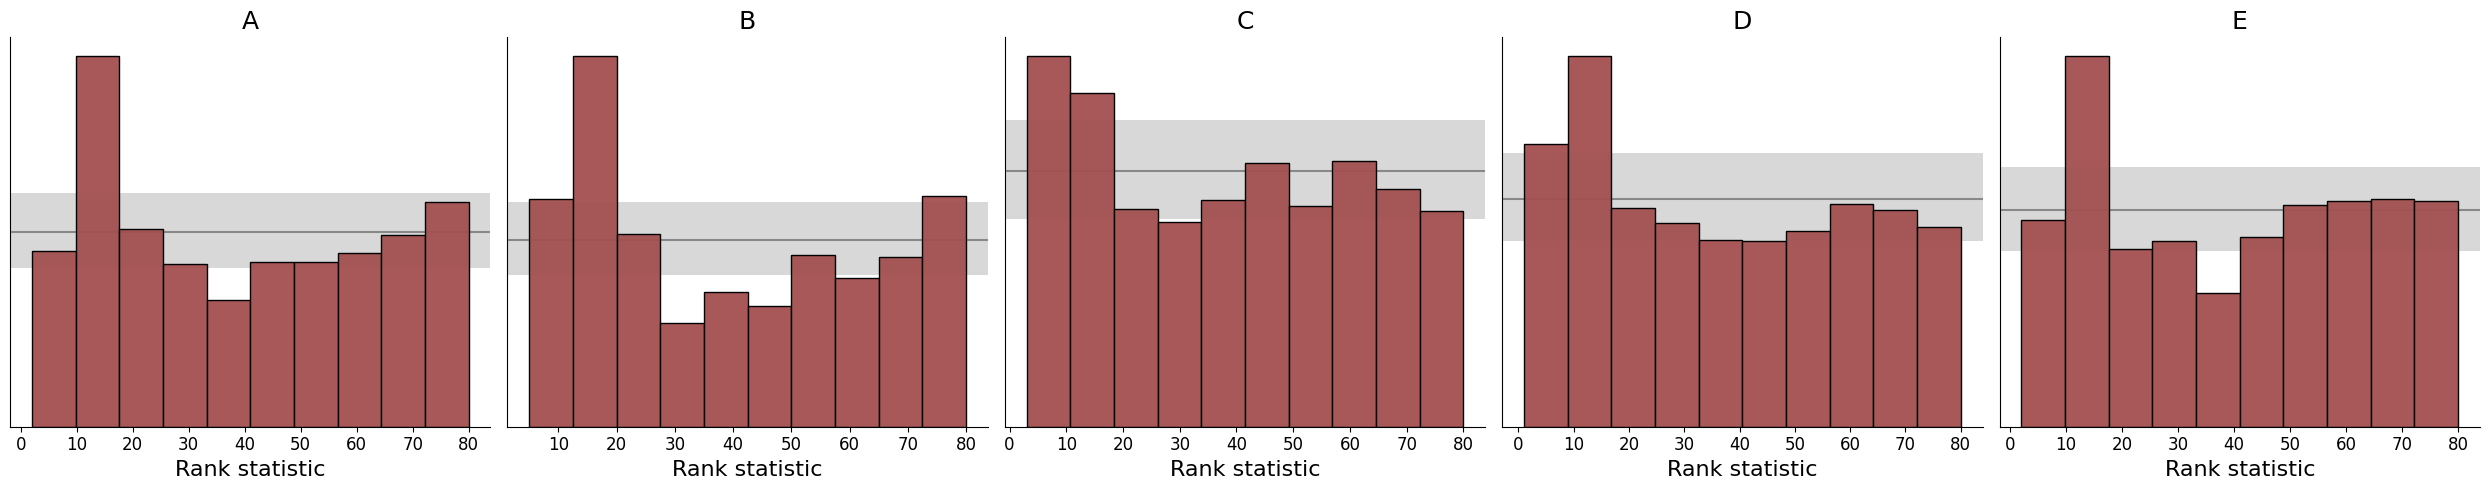

In [ ]:
f = trainer.diagnose_sbc_histograms()

In [ ]:
# Generate some validation data
validation_sims = trainer.configurator(model(batch_size=300))

# Generate posterior draws for all simulations
post_samples = amortizer.sample(validation_sims, n_samples=100)

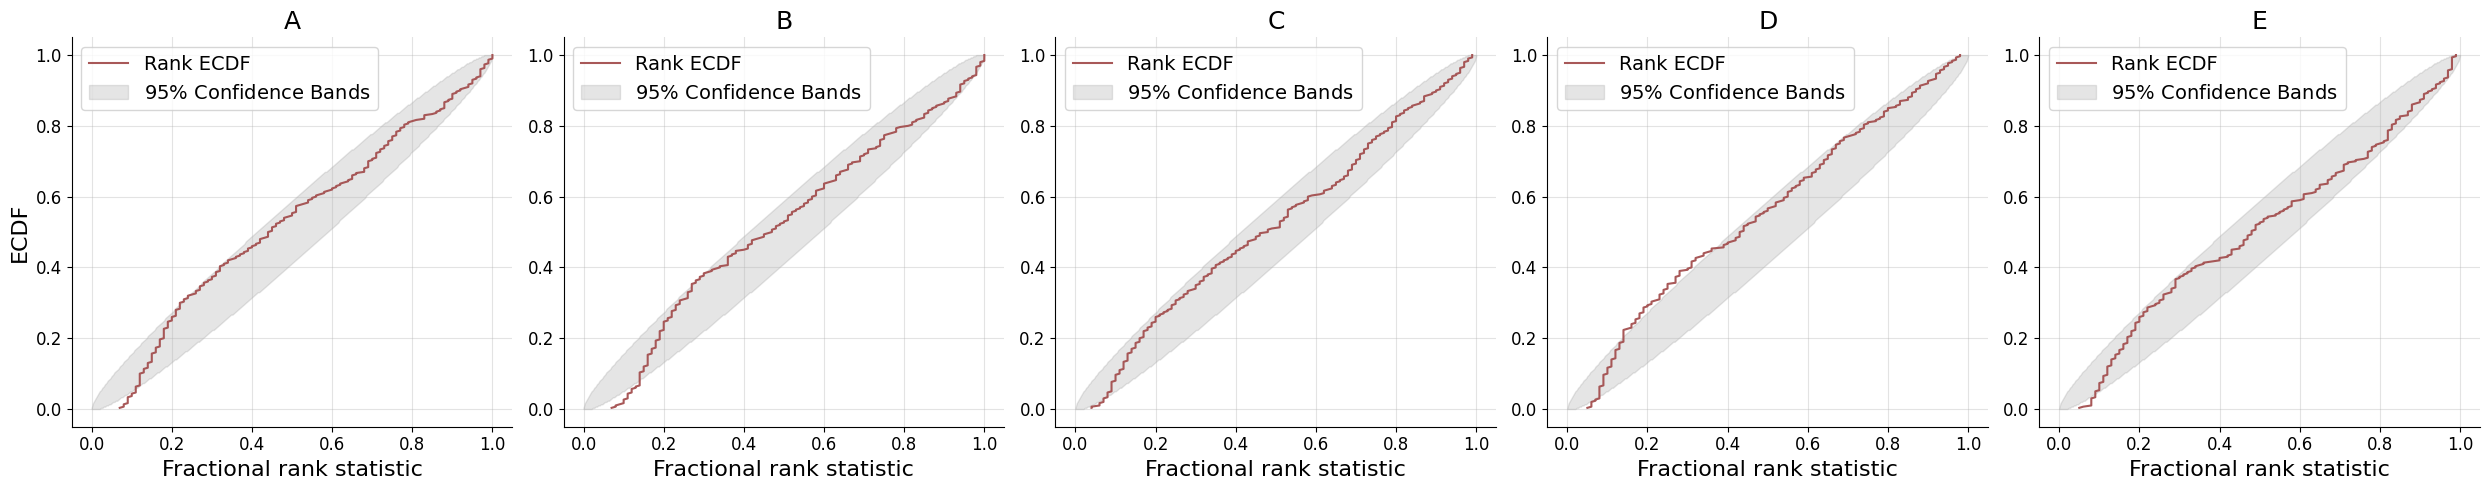

In [ ]:
# Create ECDF plot
f = diag.plot_sbc_ecdf(post_samples, validation_sims["parameters"], param_names=prior.param_names)

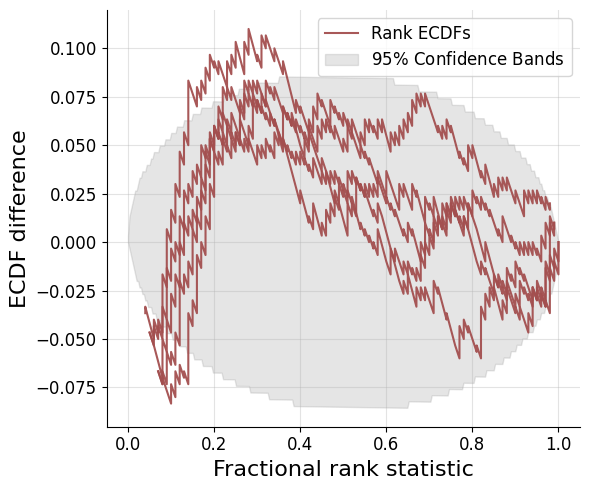

In [ ]:
f = diag.plot_sbc_ecdf(
    post_samples, validation_sims["parameters"], stacked=True, difference=True, legend_fontsize=12, fig_size=(6, 5)
)

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 3.                    Confidence intervals might be unreliable!


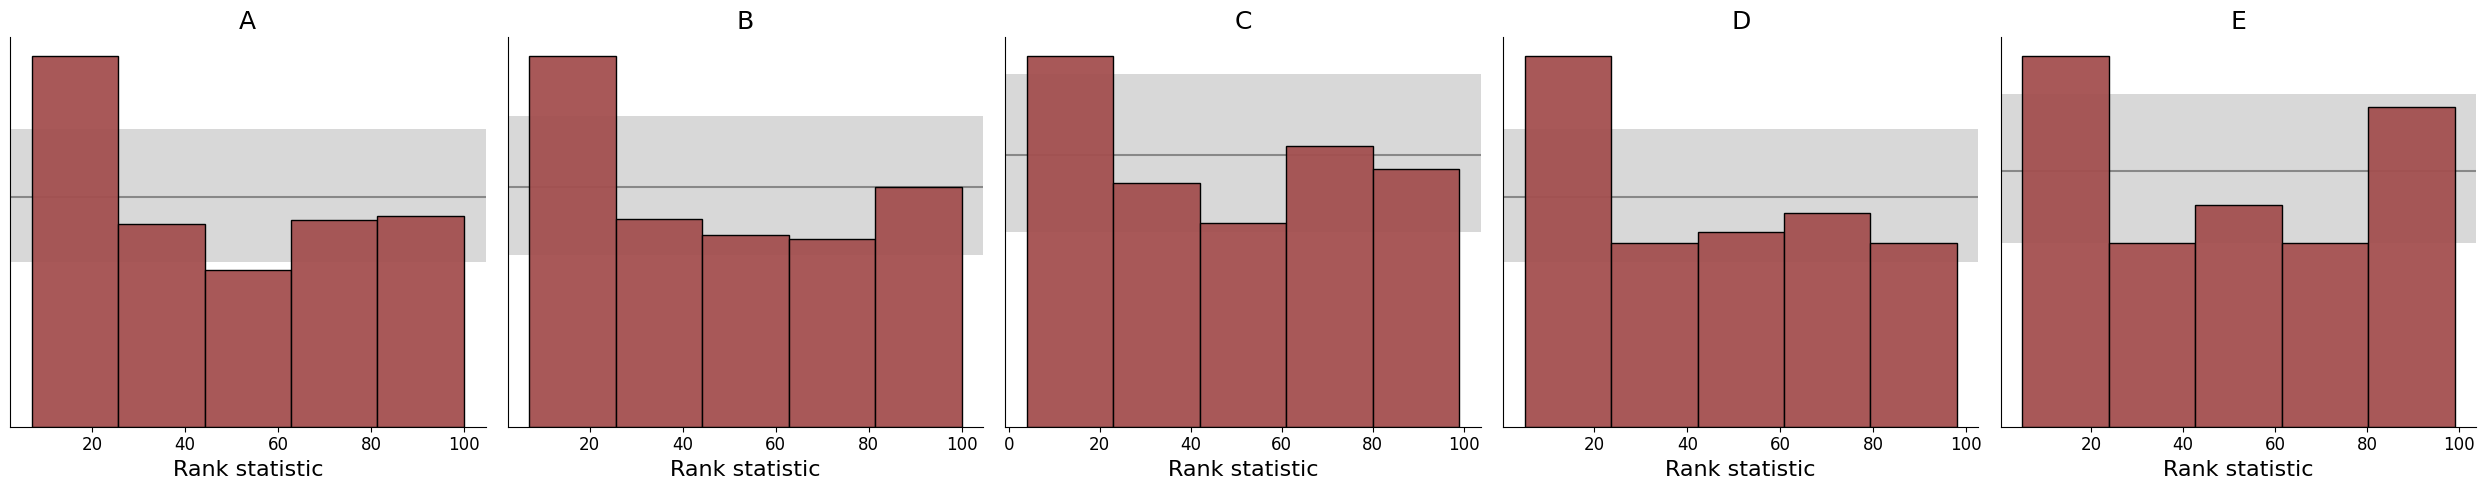

In [ ]:
f = diag.plot_sbc_histograms(post_samples, validation_sims["parameters"], param_names=prior.param_names)

In [ ]:
post_samples = amortizer.sample(validation_sims, n_samples=1000)

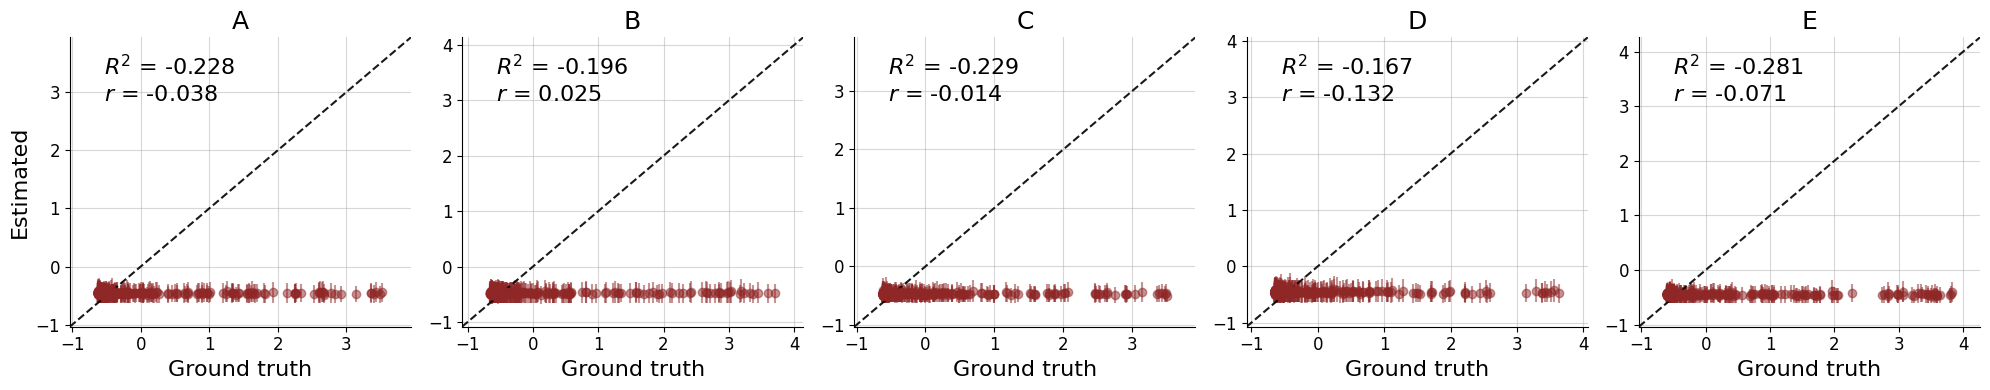

In [ ]:
f = diag.plot_recovery(post_samples, validation_sims["parameters"], param_names=prior.param_names)